In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


In [2]:
driver = pd.read_csv('datasets/driver_ids.csv')
ride = pd.read_csv('datasets/ride_ids.csv')
time = pd.read_csv('datasets/ride_timestamps.csv')

In [3]:
ride.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


# Cleaning/Reformatting Data Sets 

*Driver*

In [4]:
def driver_cleaner(df):
    df['driver_onboard_date'] = pd.to_datetime(df['driver_onboard_date']) # convert to date time for easier manipulation
    return df

In [5]:
enriched_driver = driver_cleaner(driver)
enriched_driver.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29
1,007f0389f9c7b03ef97098422f902e62,2016-03-29
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23
4,01674381af7edd264113d4e6ed55ecda,2016-04-29


*Ride*

In [6]:
def ride_cleaner(df):    
    ride = df.copy()
    ride['ride_prime_time'] = ride['ride_prime_time']/100 # change to percentage 
    ride.columns = ['driver_id','ride_id','ride_distance (meters)',
                  'ride_duration (seconds)','ride_prime_time (percentage)'] # rename columns 
    ride['ride_distance (miles)'] = ride['ride_distance (meters)']/1609.344
    ride['ride_duration (minutes)'] = ride['ride_duration (seconds)']/60
    def cost_calculator(miles_column,minutes_column,prime_time_column,tax_rate = False):
        BASE_FARE = 2
        COST_PER_MILE = 1.15
        COST_PER_MINUTE = 0.22
        SERVICE_FEE = 1.75 
        TAX_RATE = 0.085 # CHANGE 
        fare = BASE_FARE + miles_column*COST_PER_MILE + minutes_column*COST_PER_MINUTE
        if tax_rate:
            cost = SERVICE_FEE + fare + fare*prime_time_column + fare*TAX_RATE
        else: 
            cost = SERVICE_FEE + fare + fare*prime_time_column
        return cost
    ride['cost w/o prime time'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],0)
    ride['cost w/ prime time'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],
                                                 ride['ride_prime_time (percentage)'])
    ride['cost w/ prime time and tax'] = cost_calculator(ride['ride_distance (miles)'],ride['ride_duration (minutes)'],
                                                 ride['ride_prime_time (percentage)'],True)
    def cost_regulator(x):
        MINIMUM_FARE = 5
        MAXIMUM_FARE = 400
        if x < MINIMUM_FARE:
            return MINIMUM_FARE
        elif x > MAXIMUM_FARE:
            return MAXIMUM_FARE 
        else:
            return x
    ride['cost w/ prime time'] = ride['cost w/ prime time'].apply(cost_regulator)
    ride['lyft profit'] = (ride['cost w/ prime time'] - 1.75)*.2 
    return ride

In [7]:
enriched_ride = ride_cleaner(ride)
enriched_ride.head()

,driver_id,ride_id,ride_distance (meters),ride_duration (seconds),ride_prime_time (percentage),ride_distance (miles),ride_duration (minutes),cost w/o prime time,cost w/ prime time,cost w/ prime time and tax,lyft profit
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,0.50,1.125303,5.450000,6.243099,8.489648,8.871561,1.347930
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0.00,2.089050,13.483333,9.118741,9.118741,9.745084,1.473748
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0.00,2.039340,9.533333,8.192575,8.192575,8.740193,1.288515
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,0.25,40.564976,55.633333,62.639055,77.861319,83.036889,15.222264
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,1.00,2.556942,13.716667,9.708150,17.666301,18.342744,3.183260


*time*

In [83]:
def time_cleaner(df):
    time = df.copy()
    time['timestamp'] = pd.to_datetime(time['timestamp'])
    # change from 5 rows to 1 row with 5 data points 
    mod_time = time.pivot(index='ride_id', columns='event', values='timestamp').reset_index()
    # reorder columns to make more sense 
    mod_time = mod_time[['ride_id','requested_at','accepted_at','arrived_at','picked_up_at','dropped_off_at']]
    # how long a person had to wait before someone accepted their ride request
    mod_time['duration_request_to_accept'] = (mod_time['accepted_at']-mod_time['requested_at']).apply(lambda x: x.total_seconds())
    # how long it took driver to drive to location of person
    mod_time['duration_accept_to_arrive'] = (mod_time['arrived_at']-mod_time['accepted_at']).apply(lambda x: x.total_seconds())
    # how long the driver waited for the person to get into the car
    mod_time['duration_arrived_to_pickup'] = (mod_time['picked_up_at']-mod_time['arrived_at']).apply(
        lambda x: np.nan if x < pd.Timedelta(0) else x.total_seconds())
    # how long the actual trip was 
    mod_time['duration_ride'] = (mod_time['dropped_off_at']-mod_time['picked_up_at']).apply(lambda x: x.total_seconds())
    return mod_time

In [84]:
enriched_time = time_cleaner(time)
enriched_time.head()

event,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05,32.0,280.0,2.0,1112.0
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17,4.0,172.0,1.0,479.0
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18,5.0,255.0,3.0,406.0
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47,7.0,328.0,4.0,332.0
4,0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:11:38,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:16:55,2016-04-26 18:24:14,37.0,277.0,3.0,439.0


## Merged Sets

In [85]:
enriched_ride_simple = enriched_ride[['driver_id','ride_id','ride_distance (miles)', 'ride_duration (minutes)', 
                               'ride_prime_time (percentage)','cost w/ prime time','lyft profit']]

there are 937 unique ID's in ride dataset and 937 unique ID's in driver dataset. However, only 854 of the unique ID's match between the two datasets 

In [86]:
matches = enriched_ride_simple.merge(enriched_driver, how = 'inner')
matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29


We have 185891 rides still with additional driver information, which is not bad (originally we had 193502 rides). The next following dataframes are the items that have missing info (whether it be missing driver information or drivers with no documented rides)

In [87]:
overall = enriched_ride_simple.merge(enriched_driver, how = 'outer')
# we don't have driver information for these data points 
no_driver_info = overall[overall['driver_onboard_date'].isnull()]
no_driver_info.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
3687,056175954c78be4c4de7e80167b7e1f9,0488679087be6f76612dfc9ecba227e5,1.285617,6.783333,0.0,6.720793,0.994159,NaT
3688,056175954c78be4c4de7e80167b7e1f9,060d6b3e4916e1aec8cc1e746f6fd87e,1.048875,6.150000,0.0,6.309206,0.911841,NaT
3689,056175954c78be4c4de7e80167b7e1f9,075f23b3edafd5020837b14b79d7b9e8,8.010096,21.933333,0.0,17.786944,3.207389,NaT
3690,056175954c78be4c4de7e80167b7e1f9,0d4727f995ee19c0ed4654b0a5a82176,1.282510,7.216667,0.0,6.812553,1.012511,NaT
3691,056175954c78be4c4de7e80167b7e1f9,0f1f969a4ddc30c8c9c14509156e3149,2.491698,15.733333,0.0,10.076787,1.665357,NaT


In [88]:
overall = enriched_ride_simple.merge(enriched_driver, how = 'outer')
# these drivers dont have documented rides 
driver_that_has_no_rides = overall[overall['ride_id'].isnull()]
driver_that_has_no_rides.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date
193502,01788cf817698fe68eaecd7eb18b2f72,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-06
193503,133faf644d5cfee9460b87eea4367f92,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-08
193504,13fe6713788e9b63f57950320f260512,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-05
193505,146cd888491dd0f348575244f5bbc24e,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-16
193506,1585fa96f0818e8f4d1cf826b332fda4,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-06


Now we can go ahead and merge with the time data so that we have a full dataset.

In [89]:
final_matches = matches.merge(enriched_time, how = 'inner')
final_matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,25.0,141.0,4.0,327.0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,3.0,185.0,4.0,809.0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,8.0,293.0,3.0,572.0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,4.0,167.0,0.0,3338.0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,2.0,91.0,NaN,823.0


We have 184209 data points with driver, ride, and time information, which is still a lot of data! We might go back later on to see what can be done about rides missing time data, but time data missing rides is relatively not useful.

## Answering the Questions

In [90]:
# LIFETIME VALUE AVERAGES 



In [91]:
def work_expectancy_df(df):
    part_one = pd.DataFrame(df.groupby('driver_id')['driver_onboard_date'].min()).reset_index()
    part_two = pd.DataFrame(df.groupby('driver_id')['dropped_off_at'].max()).reset_index()
    important_times = part_one.merge(part_two)
    important_times['worktime_expectancy'] = important_times['dropped_off_at']-important_times['driver_onboard_date']
    def date_conversion(x):
        return x.days
    important_times['worktime_expectancy (days)'] = important_times['worktime_expectancy'].apply(date_conversion)
    important_times = important_times[['driver_id','worktime_expectancy (days)']]
    return important_times

In [92]:
summary_of_worktime = work_expectancy_df(final_matches)
summary_of_worktime.head()

,driver_id,worktime_expectancy (days)
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [93]:
overall_costs = pd.DataFrame(final_matches.groupby('driver_id')[['cost w/ prime time','lyft profit']]
                             .sum()).reset_index()

In [94]:
summary = summary_of_worktime.merge(overall_costs)
summary.head()

,driver_id,worktime_expectancy (days),cost w/ prime time,lyft profit
0,002be0ffdc997bd5c50703158b7c2491,86,3560.922468,615.234494
1,007f0389f9c7b03ef97098422f902e62,85,321.494698,53.448940
2,011e5c5dfc5c2c92501b8b24d47509bc,68,482.427855,84.585571
3,0152a2f305e71d26cc964f8d4411add9,64,2610.868733,455.323747
4,01674381af7edd264113d4e6ed55ecda,56,5381.091520,944.968304


In [102]:
number_of_drives = final_matches.groupby('driver_id')[['ride_id']].count().reset_index()
more_stuff = summary.merge(number_of_drives)
def group_decider(x):
    if x < 100:
        return 0
    else: 
        return 1 
more_stuff['group'] = more_stuff['ride_id'].apply(group_decider)
more_stuff.columns = ['driver_id','worktime_expectancy (days)','cost w/ prime time', 'lyft profit', 'number drives', 'group']
more_stuff.head()


,driver_id,worktime_expectancy (days),cost w/ prime time,lyft profit,number drives,group
0,002be0ffdc997bd5c50703158b7c2491,86,3560.922468,615.234494,277,1
1,007f0389f9c7b03ef97098422f902e62,85,321.494698,53.448940,31,0
2,011e5c5dfc5c2c92501b8b24d47509bc,68,482.427855,84.585571,34,0
3,0152a2f305e71d26cc964f8d4411add9,64,2610.868733,455.323747,191,1
4,01674381af7edd264113d4e6ed55ecda,56,5381.091520,944.968304,375,1


In [110]:
fuck_shit = more_stuff[['driver_id','worktime_expectancy (days)','number drives','group']]

In [108]:
final_matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,25.0,141.0,4.0,327.0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,3.0,185.0,4.0,809.0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,8.0,293.0,3.0,572.0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,4.0,167.0,0.0,3338.0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,2.0,91.0,NaN,823.0


In [112]:
wowie = final_matches.merge(fuck_shit)
wowie.to_csv('megasexy.csv')

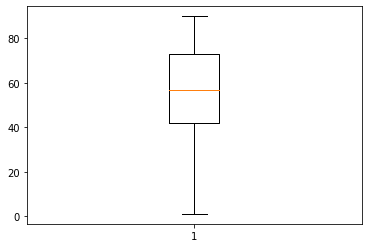

In [96]:
# NO OUTLIERS, DON'T NEED TO GET RID OF ANY OF THE WORKTIME EXPECTANCIES
plt.boxplot(more_stuff['worktime_expectancy (days)'],showfliers = True);

In [97]:
stats.skew(more_stuff['worktime_expectancy (days)'],bias = True) # negative skewness, skewed left 
# because absolute value of skewness is less than .5, we can say that the data is relatively normal 
# https://support.minitab.com/en-us/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/data-concepts/how-skewness-and-kurtosis-affect-your-distribution/

-0.482987961197601

In [98]:
stats.kurtosis(more_stuff['worktime_expectancy (days)']) 
# less outlier prone 

-0.5571842645119176

Text(0, 0.5, 'density')

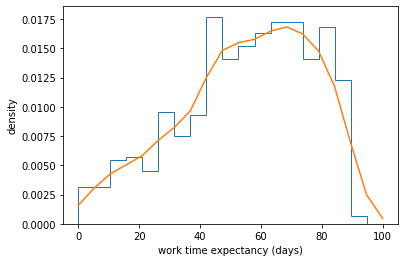

In [99]:
n, x, _ = plt.hist(more_stuff['worktime_expectancy (days)'],bins=np.linspace(0, 100, 20),histtype=u'step',density=True);
density = stats.gaussian_kde(more_stuff['worktime_expectancy (days)'])
plt.plot(x, density(x))
plt.xlabel('work time expectancy (days)')
plt.ylabel('density')

In [100]:
more_stuff['worktime_expectancy (days)'].describe()

count    837.000000
mean      55.105137
std       21.726518
min        1.000000
25%       42.000000
50%       57.000000
75%       73.000000
max       90.000000
Name: worktime_expectancy (days), dtype: float64

The average amount of days worked is 57 days (the median). We used the median because the data is generally normal, and has no outliers.

In [101]:
# determining line of best fit

"\nax.set_title('lyft profit vs. life time');\nax.plot(np.unique(group_one['worktime_expectancy (days)']), np.poly1d(\n    np.polyfit(group_one['worktime_expectancy (days)'], group_one['lyft profit'], 1))(\n    np.unique(group_one['worktime_expectancy (days)'])), color='black', linewidth = '2');\nax.plot(np.unique(group_two['worktime_expectancy (days)']), np.poly1d(\n    np.polyfit(group_two['worktime_expectancy (days)'], group_two['lyft profit'], 1))(\n    np.unique(group_two['worktime_expectancy (days)'])),color='black', linewidth = '2');\nax.plot(np.unique(more_stuff['worktime_expectancy (days)']), np.poly1d(\n    np.polyfit(more_stuff['worktime_expectancy (days)'], more_stuff['lyft profit'], 1))(\n    np.unique(more_stuff['worktime_expectancy (days)'])),color='red', linewidth = '2');\n    "

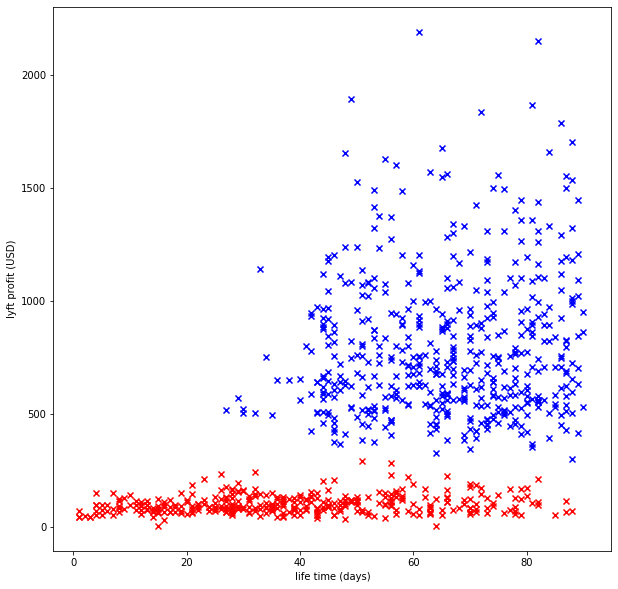

In [27]:
group_one = more_stuff[more_stuff['group']==0]
group_two = more_stuff[more_stuff['group']==1]
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['lyft profit'], marker = 'x',color = 'red')
ax.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['lyft profit'], marker = 'x',color= 'blue')
ax.set_xlabel('life time (days)')
ax.set_ylabel('lyft profit (USD)');

# ax.plot([0, summary['worktime_expectancy (days)'].max()], [100, 100], 'k-', lw=2)
'''
ax.set_title('lyft profit vs. life time');
ax.plot(np.unique(group_one['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(group_one['worktime_expectancy (days)'], group_one['lyft profit'], 1))(
    np.unique(group_one['worktime_expectancy (days)'])), color='black', linewidth = '2');
ax.plot(np.unique(group_two['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(group_two['worktime_expectancy (days)'], group_two['lyft profit'], 1))(
    np.unique(group_two['worktime_expectancy (days)'])),color='black', linewidth = '2');
ax.plot(np.unique(more_stuff['worktime_expectancy (days)']), np.poly1d(
    np.polyfit(more_stuff['worktime_expectancy (days)'], more_stuff['lyft profit'], 1))(
    np.unique(more_stuff['worktime_expectancy (days)'])),color='red', linewidth = '2');
    '''

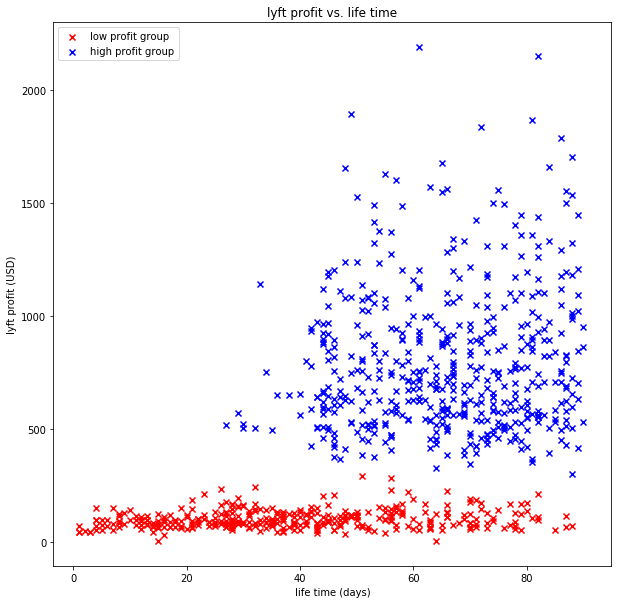

In [28]:
group_one = more_stuff[more_stuff['group']==0]
group_two = more_stuff[more_stuff['group']==1]
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['lyft profit'], marker = 'x',color='red',label='low profit group')
ax.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['lyft profit'], marker = 'x',color='blue',label='high profit group')
ax.set_xlabel('life time (days)')
ax.set_ylabel('lyft profit (USD)')
ax.legend()

#ax.plot([0, summary['worktime_expectancy (days)'].max()], [70, 70], 'k-', lw=2)
ax.set_title('lyft profit vs. life time');

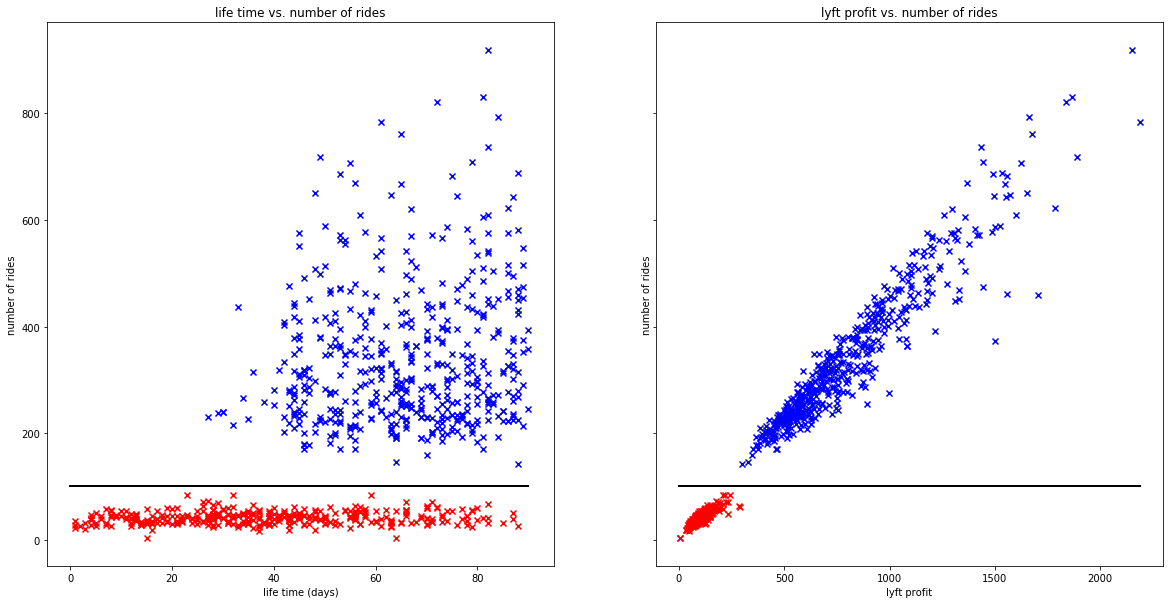

In [29]:
group_one = more_stuff[more_stuff['group']==0]
group_two = more_stuff[more_stuff['group']==1]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
ax1.scatter(x=group_one['worktime_expectancy (days)'],y=group_one['ride_id'], marker = 'x',color='red')
ax1.scatter(x=group_two['worktime_expectancy (days)'],y=group_two['ride_id'], marker = 'x',color='blue')
ax1.plot([0, more_stuff['worktime_expectancy (days)'].max()], [100, 100], 'k-', lw=2)
ax1.set_xlabel('life time (days)')
ax1.set_ylabel('number of rides')
ax1.set_title('life time vs. number of rides');

ax2.scatter(x = group_one['lyft profit'], y = group_one['ride_id'], marker = 'x',color='red')
ax2.scatter(x = group_two['lyft profit'], y = group_two['ride_id'], marker = 'x',color='blue')
ax2.plot([0, more_stuff['lyft profit'].max()], [100, 100], 'k-', lw=2)
ax2.set_xlabel('lyft profit')
ax2.set_ylabel('number of rides')
ax2.set_title('lyft profit vs. number of rides');



In [30]:
final_matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,00:00:25,00:02:21,00:00:04,00:05:27
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,00:00:03,00:03:05,00:00:04,00:13:29
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,00:00:08,00:04:53,00:00:03,00:09:32
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,00:00:04,00:02:47,00:00:00,00:55:38
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,00:00:02,00:01:31,-1 days +23:59:59,00:13:43


In [43]:
final_matches.iloc[4]['duration_arrived_to_pickup'].total_seconds() 

-1.0

In [48]:
final_matches['duration_request_to_accept'] = final_matches['duration_request_to_accept'].apply(lambda x: x.total_seconds())
final_matches['duration_accept_to_arrive'] = final_matches['duration_accept_to_arrive'].apply(lambda x: x.total_seconds())
final_matches['duration_arrived_to_pickup'] = final_matches['duration_arrived_to_pickup'].apply(lambda x: x.total_seconds())
final_matches['duration_ride'] = final_matches['duration_ride'].apply(lambda x: x.total_seconds())




In [78]:
def group_decider(x):
    if x < 100:
        return 0
    else: 
        return 1 
final_matches['group'] = final_matches['ride_id'].apply(group_decider)

TypeError: '<' not supported between instances of 'str' and 'int'

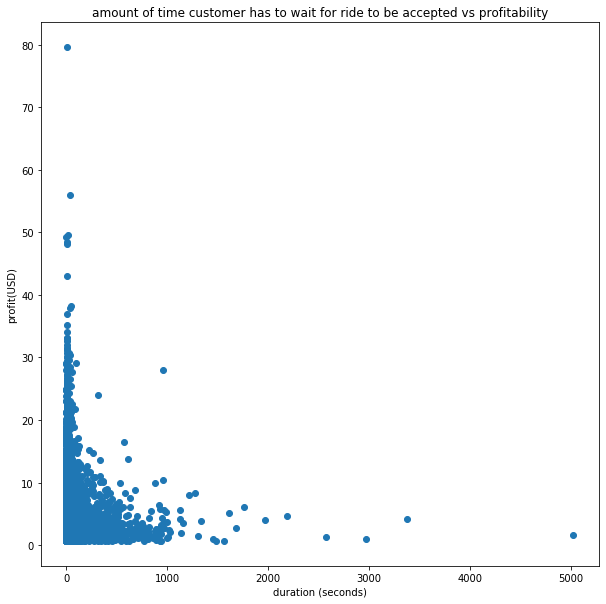

In [75]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=final_matches['duration_request_to_accept'],y=final_matches['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('amount of time customer has to wait for ride to be accepted vs profitability');

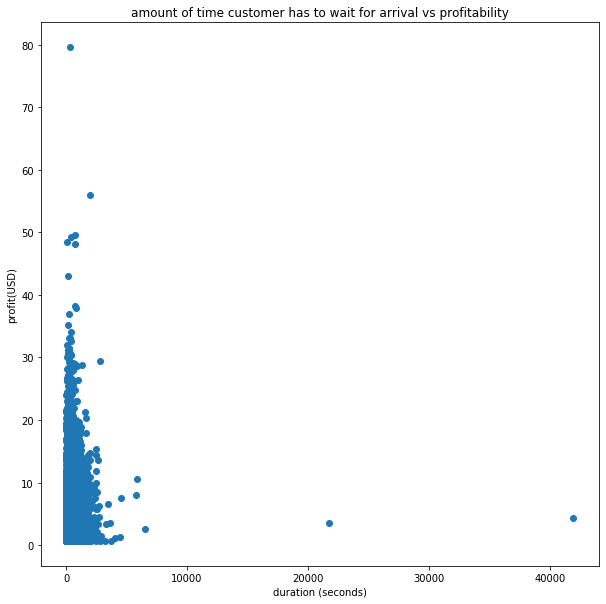

In [76]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=final_matches['duration_accept_to_arrive'],y=final_matches['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('amount of time customer has to wait after acceptance vs profitability');

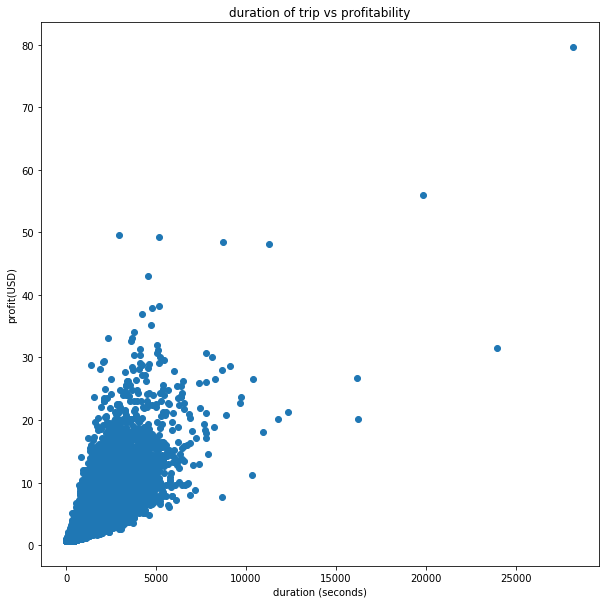

In [77]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=final_matches['duration_ride'],y=final_matches['lyft profit'])
ax.set_xlabel('duration (seconds)')
ax.set_ylabel('profit(USD)')
ax.set_title('duration of trip vs profitability');

In [49]:
final_matches.head()

,driver_id,ride_id,ride_distance (miles),ride_duration (minutes),ride_prime_time (percentage),cost w/ prime time,lyft profit,driver_onboard_date,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at,duration_request_to_accept,duration_accept_to_arrive,duration_arrived_to_pickup,duration_ride
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.125303,5.450000,0.50,8.489648,1.347930,2016-03-29,2016-04-23 02:13:50,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:16:40,2016-04-23 02:22:07,25.0,141.0,4.0,327.0
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.089050,13.483333,0.00,9.118741,1.473748,2016-03-29,2016-03-29 19:00:49,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:04:01,2016-03-29 19:17:30,3.0,185.0,4.0,809.0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.039340,9.533333,0.00,8.192575,1.288515,2016-03-29,2016-06-21 11:56:31,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:01:35,2016-06-21 12:11:07,8.0,293.0,3.0,572.0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,40.564976,55.633333,0.25,77.861319,15.222264,2016-03-29,2016-05-19 09:15:29,2016-05-19 09:15:33,2016-05-19 09:18:20,2016-05-19 09:18:20,2016-05-19 10:13:58,4.0,167.0,0.0,3338.0
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2.556942,13.716667,1.00,17.666301,3.183260,2016-03-29,2016-04-20 22:05:30,2016-04-20 22:05:32,2016-04-20 22:07:03,2016-04-20 22:07:02,2016-04-20 22:20:45,2.0,91.0,-1.0,823.0


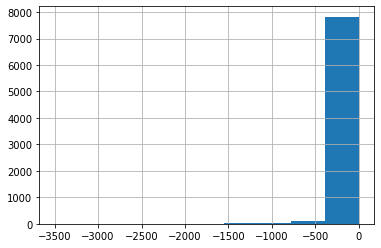

In [67]:
final_matches[final_matches['duration_arrived_to_pickup']<0]['duration_arrived_to_pickup'].hist(
    bins=np.linspace(-3500, 0, 10))

In [69]:
final_matches[final_matches['duration_arrived_to_pickup']<0]['duration_arrived_to_pickup'].value_counts()

-1.0       5567
-2.0       1533
-3.0        132
-5.0         11
-11.0        10
-6.0         10
-4.0         10
-10.0         9
-8.0          8
-13.0         6
-189.0        6
-12.0         6
-237.0        6
-248.0        5
-18.0         5
-92.0         5
-7.0          5
-14.0         5
-78.0         5
-35.0         5
-63.0         4
-44.0         4
-208.0        4
-414.0        4
-201.0        4
-15.0         4
-57.0         4
-234.0        4
-67.0         4
-135.0        4
           ... 
-1118.0       1
-1495.0       1
-645.0        1
-370.0        1
-420.0        1
-812.0        1
-115.0        1
-159.0        1
-580.0        1
-1929.0       1
-587.0        1
-447.0        1
-672.0        1
-99.0         1
-1008.0       1
-544.0        1
-100.0        1
-280.0        1
-21.0         1
-74.0         1
-76.0         1
-42.0         1
-400.0        1
-216.0        1
-17.0         1
-232.0        1
-985.0        1
-2676.0       1
-467.0        1
-461.0        1
Name: duration_arrived_t